In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from collections import defaultdict
from sklearn import metrics
from time import time
import numpy as np
import re
from nltk.corpus import stopwords
import unicodedata
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import seaborn as sns

In [2]:
# CSV "2022_Urgencia_texto_limpo.csv" with only one column, without header
# read_csv
justificativas_limpo = pd.read_csv("2022_Urgencia_texto_limpo.csv", sep=";", encoding="latin-1", header=None)

justificativas_limpo.dropna(inplace=True)

list_justificativa = justificativas_limpo[0].tolist()

print(len(list_justificativa))

384329


In [3]:
# list_justificativa = random.sample(list_justificativa, 120000)

# print(list_justificativa[:10])

In [4]:
n_comp = 50

In [5]:
count_vectorizer = CountVectorizer(max_df=0.9, min_df=0.01)
X_count = count_vectorizer.fit_transform(list_justificativa)


In [6]:
# lsa_count = make_pipeline(TruncatedSVD(n_components=n_comp), Normalizer(copy=False))
# X_count = lsa_count.fit_transform(X_count)
# explained_variance = lsa_count[0].explained_variance_ratio_.sum()

In [7]:
print(X_count.shape)

(384329, 154)


In [8]:
# count the number of entries > 0
count = (X_count[X_count > 0]).shape[1]
min_k = X_count.shape[0] * X_count.shape[1] // count
max_k = min_k * 3
min_k = min_k // 2

# true_k = 300
# cite https://dl.acm.org/doi/pdf/10.1145/99935.99938
print(min_k, max_k)

18 111


In [9]:
sample = list_justificativa
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01)
X = vectorizer.fit_transform(sample)

In [10]:
lsa = make_pipeline(TruncatedSVD(n_components=n_comp, random_state=42), Normalizer(copy=False))
X = lsa.fit_transform(X)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance:.2f} for {n_comp} components")

Explained variance of the SVD step: 0.64 for 50 components


In [11]:
res_df = pd.DataFrame(columns=['k', 'inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])

In [12]:
for k in range(min_k, max_k+1):
    print(f"Running kmeans for k={k}")
    # running kmeans
    model = KMeans(n_clusters=k, init='k-means++', max_iter=200, n_init=1, random_state=42).fit(X)

    labels=model.labels_

    inertia = model.inertia_
    silhouette = metrics.silhouette_score(X, labels, metric='euclidean', sample_size=40000, random_state=42)
    calinski_harabasz = metrics.calinski_harabasz_score(X, labels)
    davies_bouldin = metrics.davies_bouldin_score(X, labels)

    res_df.loc[len(res_df)] = {'k': k, 'inertia': inertia, 'silhouette': silhouette,
                            'calinski_harabasz': calinski_harabasz, 'davies_bouldin': davies_bouldin}

Running kmeans for k=18
Running kmeans for k=19
Running kmeans for k=20
Running kmeans for k=21
Running kmeans for k=22
Running kmeans for k=23
Running kmeans for k=24
Running kmeans for k=25
Running kmeans for k=26
Running kmeans for k=27
Running kmeans for k=28
Running kmeans for k=29
Running kmeans for k=30
Running kmeans for k=31
Running kmeans for k=32
Running kmeans for k=33
Running kmeans for k=34
Running kmeans for k=35
Running kmeans for k=36
Running kmeans for k=37
Running kmeans for k=38
Running kmeans for k=39
Running kmeans for k=40
Running kmeans for k=41
Running kmeans for k=42
Running kmeans for k=43
Running kmeans for k=44
Running kmeans for k=45
Running kmeans for k=46
Running kmeans for k=47
Running kmeans for k=48
Running kmeans for k=49
Running kmeans for k=50
Running kmeans for k=51
Running kmeans for k=52
Running kmeans for k=53
Running kmeans for k=54
Running kmeans for k=55
Running kmeans for k=56
Running kmeans for k=57
Running kmeans for k=58
Running kmeans f

## Elbow Method

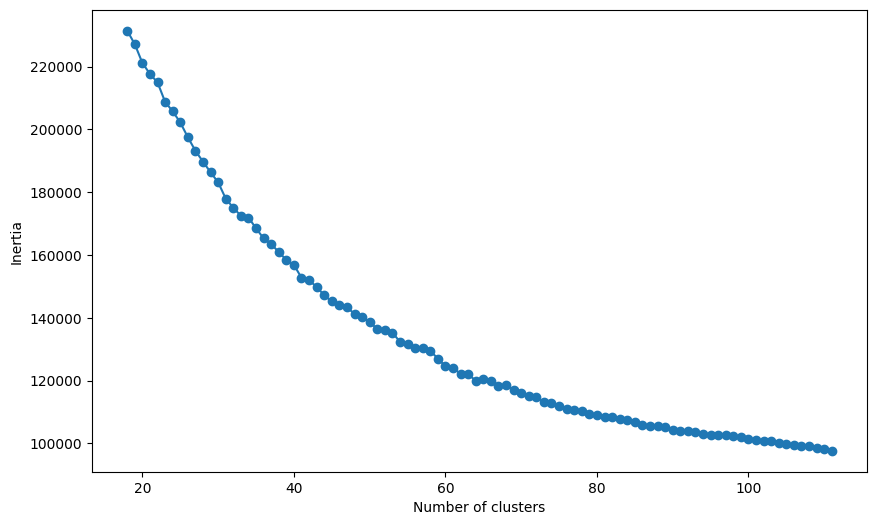

In [13]:
plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['inertia'], marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.show()


## Silhouette Coefficient

In [14]:
# max silhouette
print(res_df.loc[res_df['silhouette'].idxmax()])

k                      111.000000
inertia              97677.665471
silhouette               0.348979
calinski_harabasz     8800.819916
davies_bouldin           1.642362
Name: 93, dtype: float64


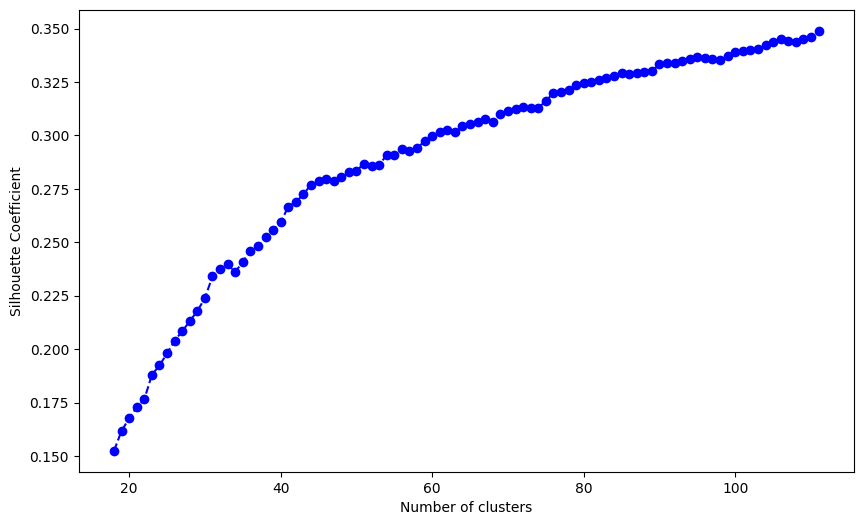

In [15]:
# 2d plot silhouette for each k

plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['silhouette'], marker='o', linestyle='--', color='b')

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

plt.show()



## Calinski-Harabasz Index

In [16]:
# max Calinski-Harabasz
print(res_df.loc[res_df['calinski_harabasz'].idxmax()])

k                        41.000000
inertia              152737.500523
silhouette                0.266625
calinski_harabasz     12017.216358
davies_bouldin            1.580497
Name: 23, dtype: float64


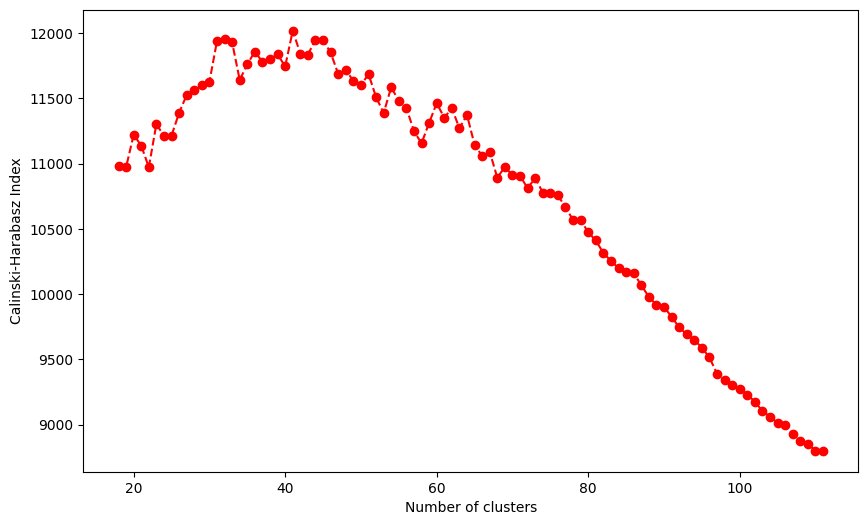

In [17]:
fig = plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['calinski_harabasz'], marker='o', linestyle='--', color='r')

plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')

plt.show()

## Davies-Bouldin Index

In [18]:
# max davies_bouldin
print(res_df.loc[res_df['davies_bouldin'].idxmin()])

k                        51.000000
inertia              136401.424252
silhouette                0.286809
calinski_harabasz     11685.342421
davies_bouldin            1.485807
Name: 33, dtype: float64


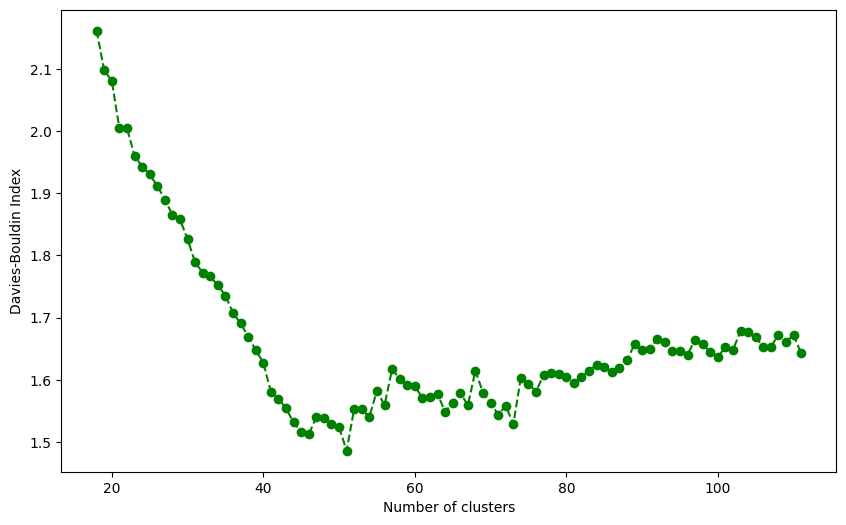

In [19]:
fig = plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['davies_bouldin'], marker='o', linestyle='--', color='g')

plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')

plt.show()

In [20]:
choosen_k = 42

In [21]:
# model = KMeans(n_clusters=choosen_k, init='k-means++', max_iter=200, n_init=1, random_state=42).fit(X)

# labels=model.labels_
# clusters=pd.DataFrame(list(zip(sample,labels)),columns=['phrase','cluster'])
# clusters['cluster'].value_counts()

In [22]:
# quantize the clusters
# clusters_count = clusters.groupby('cluster').count()
# clusters_count = clusters_count.sort_values(by=['phrase'], ascending=False)

# clusters_count.head(10)

In [23]:
# 1-D swarmplot
# sns.swarmplot(x=clusters_count['phrase'], color="red")

In [24]:

#print(clusters.sort_values(by=['cluster']))
# find the centroids
# original_space_centroids = lsa[0].inverse_transform(model.cluster_centers_)
# order_centroids = original_space_centroids.argsort()[:, ::-1]
# terms = vectorizer.get_feature_names_out()

# for i in range(10):
#     print("#Cluster TOP %d" % (i+1)),
#     print("Cluster %d:" % clusters_count.index[i])

#     for ind in order_centroids[clusters_count.index[i], :10]:
#         print(" %s" % terms[ind])

# for i in range(min_k):
#     print("Cluster %d:" % i),
#     print("Cluster size: %d" % clusters_count[clusters_count.index == i].values[0][0])
#     for ind in order_centroids[i, :10]:
#         print(" %s" % terms[ind])
#     print("------------------------------------------")

#     for phr in clusters[clusters['cluster']==i]['phrase'].unique()[:20]:
#         print("  %s" % phr)
#     print("\n")


In [25]:
#http://datamining.rutgers.edu/publication/internalmeasures.pdf

## Silhouette Coefficient

In [26]:
# metrics.silhouette_score(X, labels, metric='euclidean', sample_size=40000, random_state=42)

## Calinski-Harabasz Index

In [27]:
# metrics.calinski_harabasz_score(X, labels)

## Davies-Bouldin Index

In [28]:
# metrics.davies_bouldin_score(X, labels)